# Object Detection Code

## Albert Vo


# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import cv2
import sklearn
import sys
#sys.path

## Env setup

In [3]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [4]:
from utils import label_map_util

from utils import visualization_utils as vis_util

/root/TRAFFIC/TRAFFIC/MODELS/models/research/object_detection/utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/root/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/root/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/root/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/root/.local/li

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [5]:
# What model to download.
#MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_NAME = 'ssd_inception_v2_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')
#PATH_TO_LABELS = os.path.join('data', 'label_map.pbtxt')
NUM_CLASSES = 90
#NUM_CLASSES = 14

## Download Model

In [6]:
DOWNLOAD = False
if DOWNLOAD:
  opener = urllib.request.URLopener()
  opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
  tar_file = tarfile.open(MODEL_FILE)
  for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
      tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [7]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [8]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'name': 'person', 'id': 1}, 2: {'name': 'bicycle', 'id': 2}, 3: {'name': 'car', 'id': 3}, 4: {'name': 'motorcycle', 'id': 4}, 5: {'name': 'airplane', 'id': 5}, 6: {'name': 'bus', 'id': 6}, 7: {'name': 'train', 'id': 7}, 8: {'name': 'truck', 'id': 8}, 9: {'name': 'boat', 'id': 9}, 10: {'name': 'traffic light', 'id': 10}, 11: {'name': 'fire hydrant', 'id': 11}, 13: {'name': 'stop sign', 'id': 13}, 14: {'name': 'parking meter', 'id': 14}, 15: {'name': 'bench', 'id': 15}, 16: {'name': 'bird', 'id': 16}, 17: {'name': 'cat', 'id': 17}, 18: {'name': 'dog', 'id': 18}, 19: {'name': 'horse', 'id': 19}, 20: {'name': 'sheep', 'id': 20}, 21: {'name': 'cow', 'id': 21}, 22: {'name': 'elephant', 'id': 22}, 23: {'name': 'bear', 'id': 23}, 24: {'name': 'zebra', 'id': 24}, 25: {'name': 'giraffe', 'id': 25}, 27: {'name': 'backpack', 'id': 27}, 28: {'name': 'umbrella', 'id': 28}, 31: {'name': 'handbag', 'id': 31}, 32: {'name': 'tie', 'id': 32}, 33: {'name': 'suitcase', 'id': 33}, 34: {'name': 'frisbee

## Helper code

In [9]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [10]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 7) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [11]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

[10  3  3 10  3  3  3  3 10  1 10  3  3  3  3 10  3  3  3  3  3  3  7  3
  3  3  3  1  3  3  3  3 10  3  3  1  3 10  1  3  3  3  3  3  3  3  3  3
 10  1  3  3  3  3  3  3  9  3 16  1  3  3  3  3  3  3  3 10  3  3  3 10
  3  3  3  3 10  3  3  3  3  1  3  8  3  3  1  3  1  1 16  3  3  3  3 10
  8  3  3  3]
[ 3  3  3  3  3  3 10  3  3  3 10  1  8  3  3  3  1  3  3  3 64  3  3 10
  3  3  3  1  3  1 10  3  1 10  3  3 10 10 10 64  3 10  3  3 10  3 10 10
 10  3  1  3 64 10  3  3  1 10  1 10 10  3  3 10 10 10  3  1 10 10  3 10
  3  3  3  3  3 10  3  1  3 10  2 10  3  3  3 10  8 10 10  3 64  2 10  3
  3  3 10 64]
[10 10 10 64 64 64 64 64 10 64 64 16 10 86 64 64  1 64 64 21 64 64 10  1
 64 64 10 64 16 64 10 64  1 10 10 52 10 10  1 64  1 64 10 64  1 62 52 16
 64  1 21  1 16  1 64 64  1 10 64 64 52 52  1 13 64  1 56 21 10  1  1 52
 64  1 10 64 64  1  1 10  1 64 10  1 52 64 64  1 64  1 10  1  1  1  1 10
 64  1 64 10]
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10

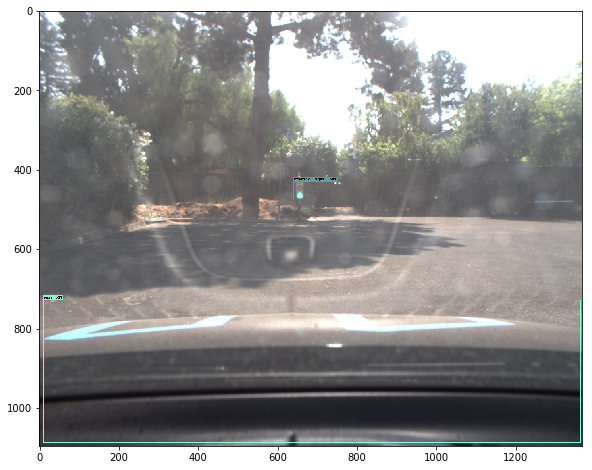

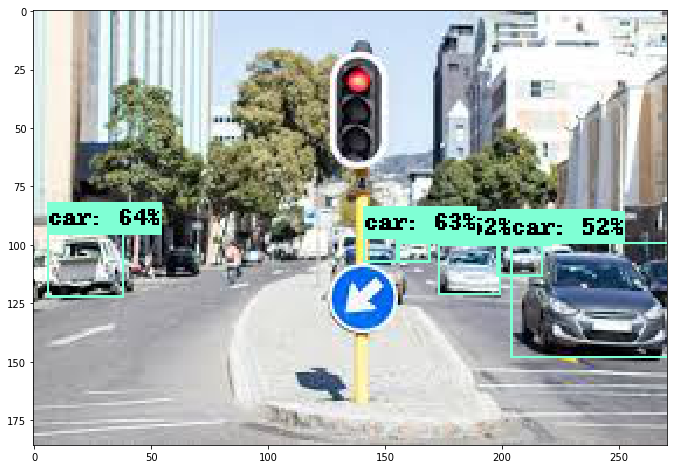

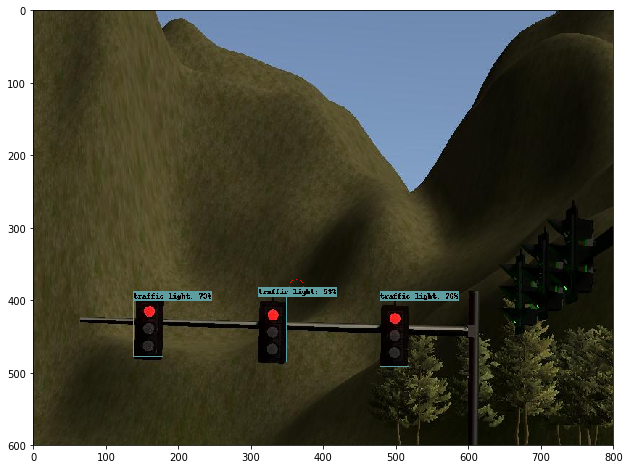

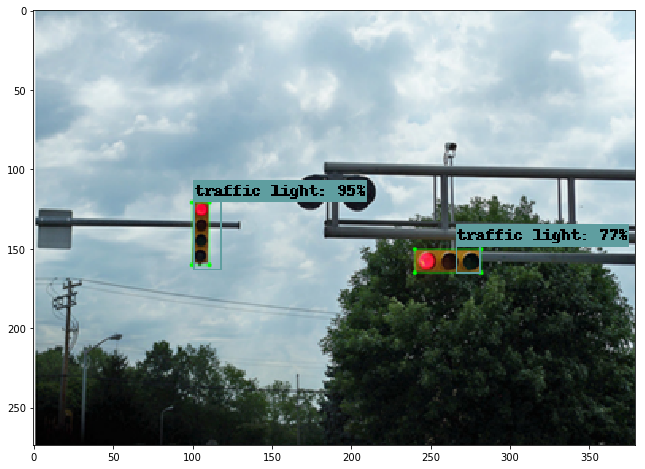

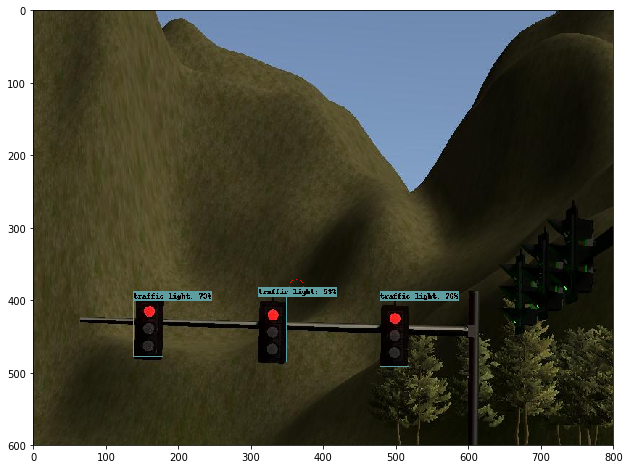

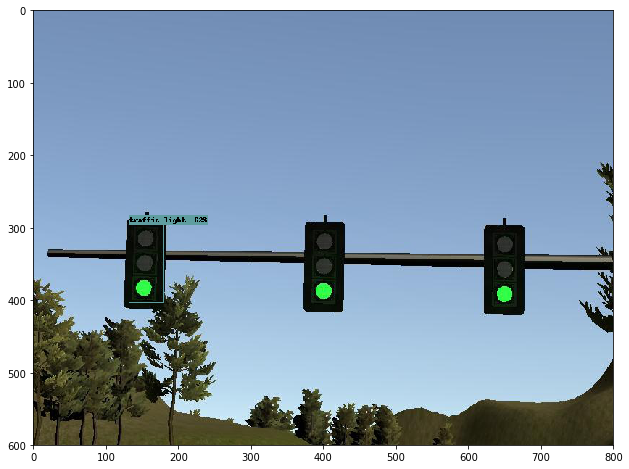

In [12]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=1)
#  if 10 in output_dict['detection_classes']:
#    print ('FOUND Traffic Light')
#    print ('score = ',output_dict['detection_scores'])
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
#  class_name = category_index[classes[i]]['name']
  print (output_dict['detection_classes'])

FOUND Traffic Light
score  0  =  0.58745825
bounding_box  0  =  [0.39250514 0.46898618 0.43494168 0.4867718 ]
width = 1096
height = 1368
w = 19
h = 59
W = 169
H = 159
ymin = 536
ymax = 595
xmin = 514
xmax = 533
FOUND Traffic Light
score  0  =  0.76821935
bounding_box  0  =  [0.66953516 0.59837586 0.8189876  0.648014  ]
width = 600
height = 800
w = 29
h = 120
W = 179
H = 220
ymin = 535
ymax = 655
xmin = 359
xmax = 388
FOUND Traffic Light
score  1  =  0.73355067
bounding_box  1  =  [0.66990525 0.17349672 0.79612917 0.22416192]
width = 600
height = 800
w = 30
h = 101
W = 180
H = 201
ymin = 535
ymax = 636
xmin = 104
xmax = 134
FOUND Traffic Light
score  2  =  0.53208077
bounding_box  2  =  [0.65913963 0.38848308 0.8086041  0.43710473]
width = 600
height = 800
w = 29
h = 119
W = 179
H = 219
ymin = 527
ymax = 646
xmin = 233
xmax = 262
FOUND Traffic Light
score  0  =  0.95339763
bounding_box  0  =  [0.44107795 0.26820195 0.5958085  0.31152004]
width = 274
height = 379
w = 12
h = 58
W = 162
H 

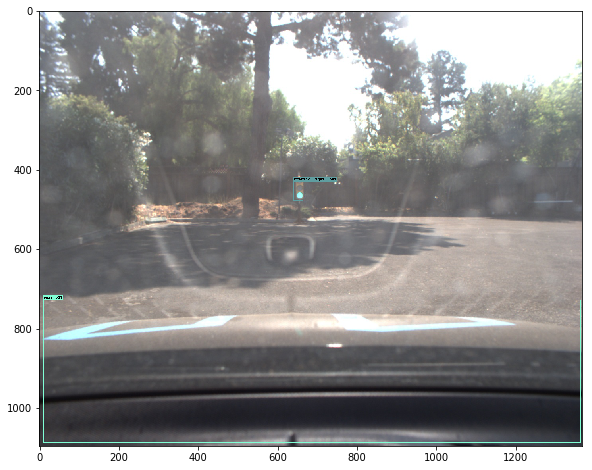

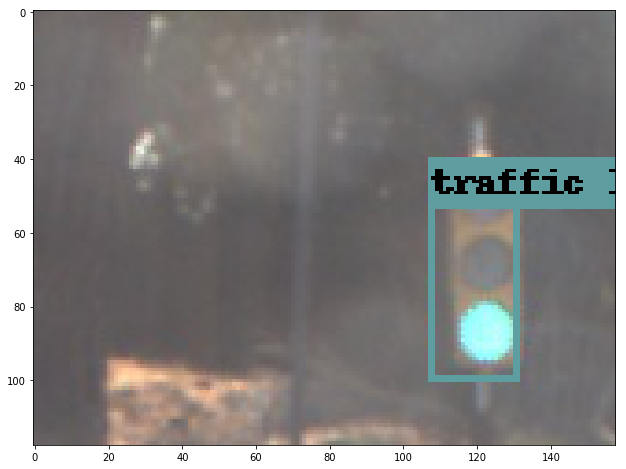

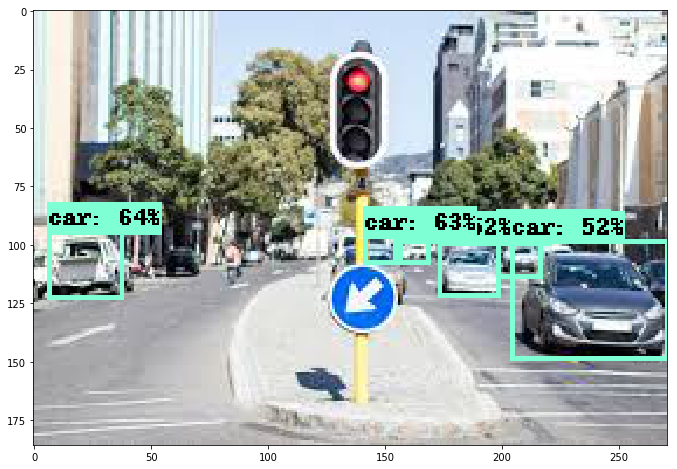

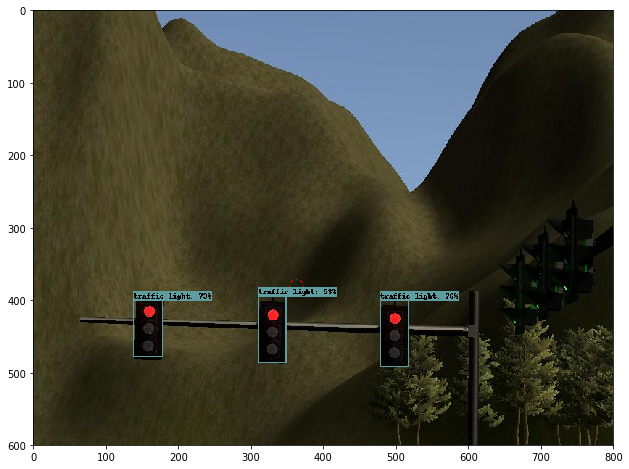

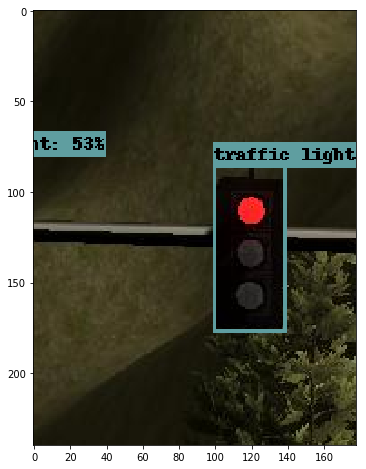

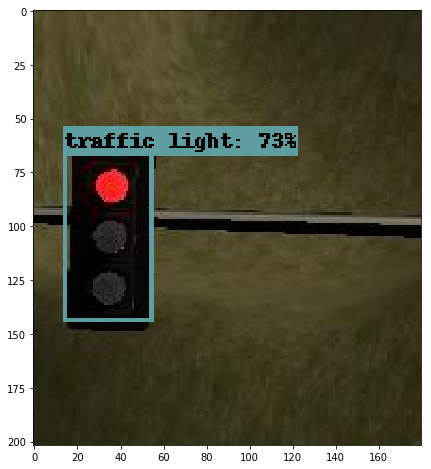

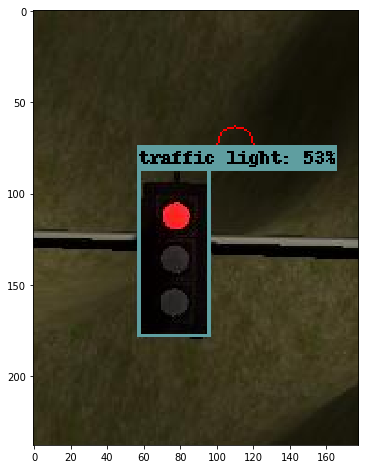

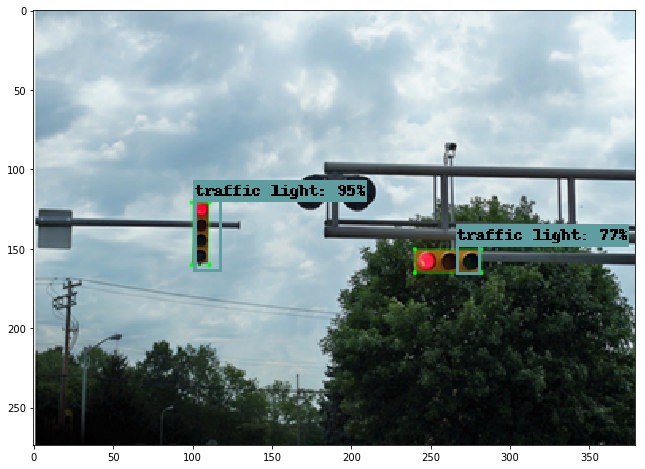

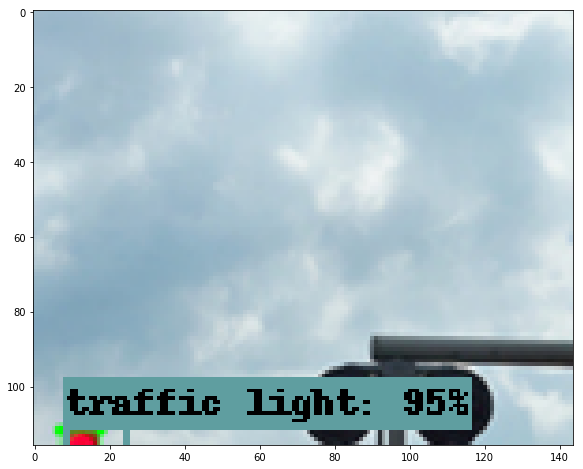

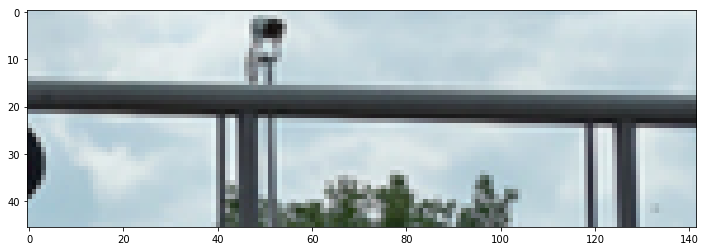

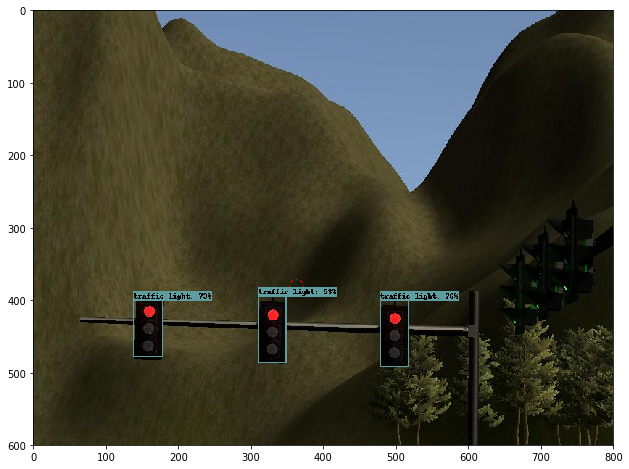

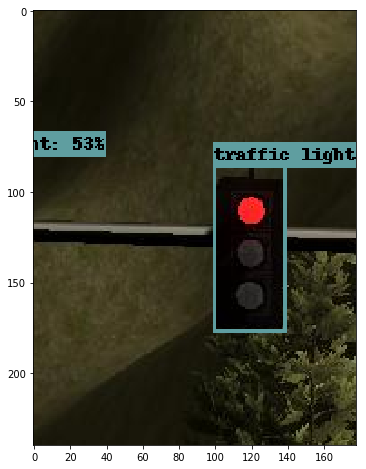

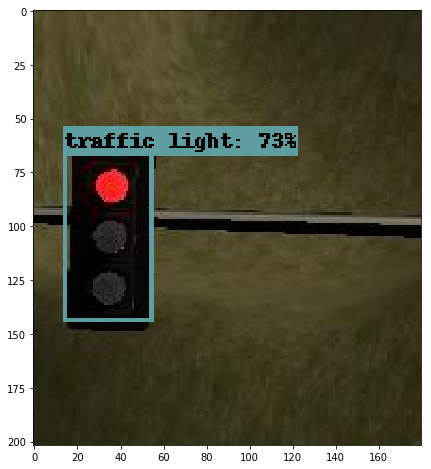

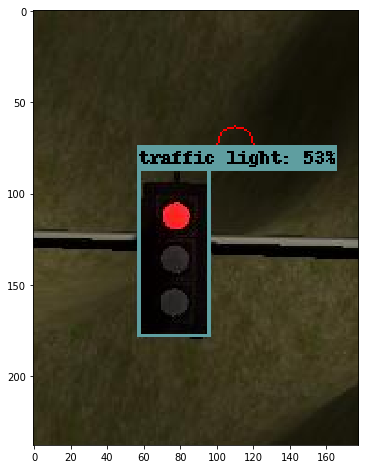

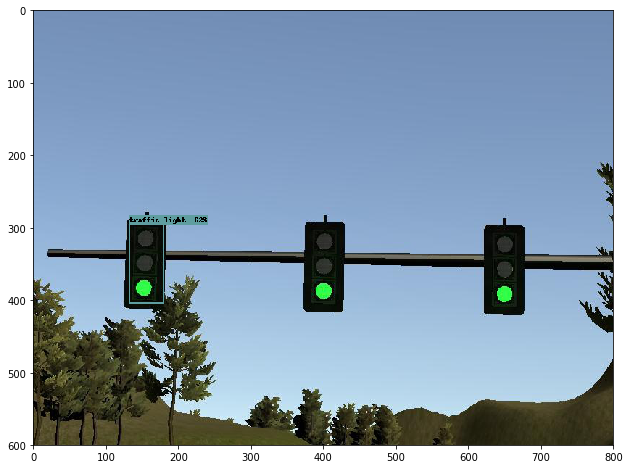

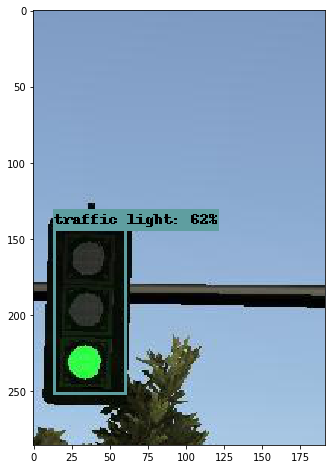

In [26]:
cnt = 0
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
#      use_normalized_coordinates=False,
      line_thickness=2)

  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
#########    

#  if 10 in output_dict['detection_classes']:
#    print ('FOUND Traffic Light')
#    print ('classes = ',output_dict['detection_classes'])
#    print ('score = ',output_dict['detection_scores'])
    
  if 10 in output_dict['detection_classes']:
    for i in range(len(output_dict['detection_classes'])):
      if output_dict['detection_classes'][i] == 10  and output_dict['detection_scores'][i] > .5:
        print ('FOUND Traffic Light')
        print ('score ',i, ' = ',output_dict['detection_scores'][i])
        print ('bounding_box ',i, ' = ',output_dict['detection_boxes'][i])
        y1 = output_dict['detection_boxes'][i][0]
        x1 = output_dict['detection_boxes'][i][1]
        y2 = output_dict['detection_boxes'][i][2]
        x2 = output_dict['detection_boxes'][i][3]
        
#        y1 = int(y1)
#        y2 = int(y2)
#        x1 = int(x1)
#        x2 = int (x2)
#        h = (y2 - y1)
#        w = (x2 - x1)
########### denormalize
#        y1 = int(y1 * 800) 
#        y2 = int(y2 * 800)
#        x1 = int(x1 * 1200)
#        x2 = int(x2 * 1200)
#        h = y2 - y1
#        w = x2 - x1
 
        width,height,_ = image_np.shape

        width = int(width)
        height = int(height)
        ymin = int(y1 * height)
        ymax = int(y2 * height)
        xmin = int(x1 * width)
        xmax = int(x2 * width)
        h = int(ymax - ymin)
        w = int(xmax - xmin)
        up = 20

#        H = h+150
#        W = w+200
        H = h+100
        W = w+150
        print ("width =", width)
        print ("height =", height)
        print ("w =", w)
        print ("h =", h)
        print ("W =", W)
        print ("H =", H)
        print ("ymin =", ymin)
        print ("ymax =", ymax)
        print ("xmin =", xmin)
        print ("xmax =", xmax)
#        ymin = boxes[0][i][0]*height
#        xmin = boxes[0][i][1]*width
#        ymax = boxes[0][i][2]*height
#        xmax = boxes[0][i][3]*width
        
#        roi = image_np[y1:y1+h, x1:x1+w]
#        roi = image_np[ymin:ymin+h, xmin:xmin+w]
#        roi = image_np[ymin:ymin+H, xmin:xmin+W]
#        if ymin < 150:
#          roi = image_np[ymin:ymax+H, xmin:xmax+W]  
#          roi = image_np[ymin:ymax+H, xmin:xmax+W]
#          roi = image_np[ymin-h:ymax+H, xmin:xmax+W]  
#        roi = image_np[ymin-up:ymax+H, xmin:xmax+W]
#!        roi = image_np[ymin-H:ymax, xmin:xmax+W]
        roi = image_np[ymin-H:ymax-100, xmin+20:xmax+W-10]
#        else:
#          roi = image_np[ymin-h:ymax+H, xmin-w:xmax+W]  
#        roi = image_np[y1:y2, x1:x2]
#        roi = image_np[ymin:ymax, xmin:xmax]
#        cv2.imwrite("roi.jpg", roi)
        plt.figure(figsize=IMAGE_SIZE)
#        ROI_SIZE = roi.shape
#        print ('ROI_SIZE =', ROI_SIZE)
#        plt.figure(figsize=ROI_SIZE)
        plt.imshow(roi)
#        roi = im[y:y+h, x:x+w]
#RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#        roi_BGR = roi

        roi_RGB = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        roi_filename = '/root/TRAFFIC/TRAFFIC/traffic-light-classifier/data/'+'roi'+str(cnt)+'.jpg'
        cv2.imwrite(roi_filename, roi_RGB)
#        cv2.imwrite(roi_filename, roi_BGR)
        cnt += 1
#        cv2.imwrite("roi.jpg", roi)

#plt.figure(figsize=IMAGE_SIZE)
#plt.imshow(roi)

In [27]:
import pickle
#import numpy as np
#import cv2
#import tensorflow as tf
#import sklearn
#from keras.models import Sequential

In [28]:

#import pickle
#import numpy as np
#import cv2
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.models import load_model


In [34]:
def network():
    """
    Define the network
    :return:
    """
    model = Sequential()
    model.add(Convolution2D(32, 3, 3, input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(4))
    model.add(Activation('softmax'))

    return model


def network2():
    model = Sequential([
    Convolution2D(16, 3, 3, border_mode='same', subsample=(2, 2), input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CLASSES), activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.2),

    Convolution2D(32, 3, 3, border_mode='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.2),

    Convolution2D(64, 3, 3, border_mode='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='tanh'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax'),
])
#model.summary()

def train(file_path, model):

    x_,y_ = pickle.load( open(file_path, "rb" ) )
    random_state = 130
    X_train, x_validation, y_train, y_validation = train_test_split(x_, y_, train_size = 0.80,
                                                                    test_size = 0.2,
                                                                    random_state = random_state)
    # preprocess data
    X_normalized = np.array(X_train / 255.0 - 0.5 )
    label_binarizer = LabelBinarizer()
    y_one_hot = label_binarizer.fit_transform(y_train)

    model.summary()
    model.compile('adam', 'categorical_crossentropy', ['accuracy'])
    history = model.fit(X_normalized, y_one_hot, nb_epoch=20, validation_split=0.2)

    model.save('model.h5')
    return history



def test(file_path, model):

    X_test,y_test = pickle.load( open(file_path, "rb" ) )

    # preprocess data
    X_normalized_test = np.array(X_test / 255.0 - 0.5 )
    label_binarizer = LabelBinarizer()
    y_one_hot_test = label_binarizer.fit_transform(y_test)

    print("Testing")

    metrics = model.evaluate(X_normalized_test, y_one_hot_test)
    for metric_i in range(len(model.metrics_names)):
        metric_name = model.metrics_names[metric_i]
        metric_value = metrics[metric_i]
        print('{}: {}'.format(metric_name, metric_value))


In [30]:
def test_an_image(file_path, model):
    """
    resize the input image to [32, 32, 3], then feed it into the NN for prediction
    :param file_path:
    :return:
    """

    desired_dim=(32,32)
    img = cv2.imread(file_path)
    img_resized = cv2.resize(img, desired_dim, interpolation=cv2.INTER_LINEAR)
    img_ = np.expand_dims(np.array(img_resized), axis=0)

    predicted_state = model.predict_classes(img_)

    return predicted_state

In [37]:
demo_flag = True
model = network()
train_file = "/root/TRAFFIC/TRAFFIC/traffic-light-classifier/data/bosch_udacity_train.p"
test_file = "/root/TRAFFIC/TRAFFIC/traffic-light-classifier/data/bosch_udacity_test.p"
# Test the network
test(test_file, model=load_model('/root/TRAFFIC/TRAFFIC/traffic-light-classifier/model.h5'))

  
#file_path = '/root/TRAFFIC/TRAFFIC/traffic-light-classifier/data/red6.jpg'
file_path = '/root/TRAFFIC/TRAFFIC/traffic-light-classifier/data/yellow2.jpg'
#file_path = '/root/TRAFFIC/TRAFFIC/traffic-light-classifier/data/green.jpg'
#file_path = '/root/TRAFFIC/TRAFFIC/traffic-light-classifier/data/roi0.jpg'
#file_path = '/root/TRAFFIC/TRAFFIC/traffic-light-classifier/data/roi1.jpg'
#file_path = '/root/TRAFFIC/TRAFFIC/traffic-light-classifier/data/roi2.jpg'
#file_path = '/root/TRAFFIC/TRAFFIC/traffic-light-classifier/data/roi3.jpg'
#file_path = '/root/TRAFFIC/TRAFFIC/traffic-light-classifier/data/roi4.jpg'
#file_path = '/root/TRAFFIC/TRAFFIC/traffic-light-classifier/data/roi5.jpg'
#file_path = '/root/TRAFFIC/TRAFFIC/traffic-light-classifier/data/roi6.jpg'
#file_path = '/root/TRAFFIC/TRAFFIC/traffic-light-classifier/data/roi7.jpg'
#file_path = '/root/TRAFFIC/TRAFFIC/traffic-light-classifier/data/roi8.jpg'
#file_path = '/root/TRAFFIC/TRAFFIC/traffic-light-classifier/data/roi9.jpg'
#file_path = '/root/TRAFFIC/TRAFFIC/traffic-light-classifier/data/yellow2.jpg'
#file_path = '/root/TRAFFIC/TRAFFIC/traffic-light-classifier/data/ROI1.jpg'
#file_path = '/root/TRAFFIC/TRAFFIC/traffic-light-classifier/data/image1.jpg'
states = ['red', 'yellow', 'green', 'off']
if demo_flag:
        predicted_state = test_an_image(file_path, model=load_model('/root/TRAFFIC/TRAFFIC/traffic-light-classifier/model.h5'))
        for idx in predicted_state:
            print(states[idx])

/root/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3...)`
  import sys
/usr/local/lib/python3.5/dist-packages/keras/models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Testing
1030/1030 [==============================] - 1s 502us/step
loss: 0.16406624296282246
acc: 0.941747572815534
yellow
